# Power of Graph Products
In this notebook we will explore the power of graph products. We will use the following graph products:
* Cartesian product
* Direct product
* Strong product
* Modular product

We will explore the use of different embeddings and the effect of different graph products on the embeddings.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

from compare import compare_embeddings as compare
from counting import BasisCycleEmbedding, ChordlessCycleEmbedding
from product.factor import get_factor_dict
from product.product_operator import generate_graph_product_table
from utils import plot_horizontally as plot
from utils import results_to_latex, save_pdf
from weisfeiler_lehman import wl_embedding as wl

pd.set_option('display.max_columns', None)

We will start by using all possible non-isomorphic graphs with a maximum of 7 nodes that are connected. This gives us a total of 995 graphs.

In [2]:
Gs = [G for G in nx.graph_atlas_g() if not nx.is_empty(G) and nx.is_connected(G)]
len(Gs)

995

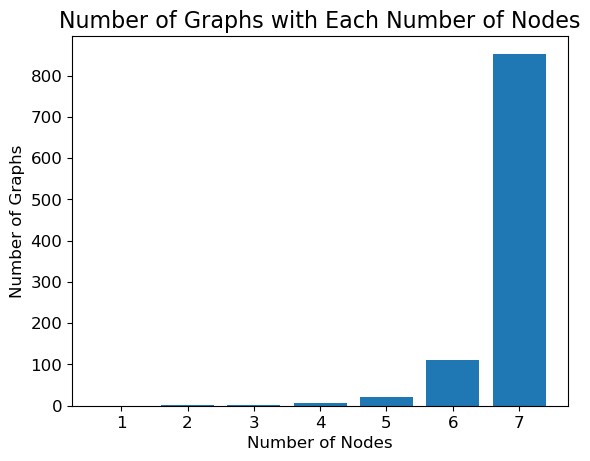

In [3]:
number_of_graphs_with_n_nodes = [len([G for G in Gs if G.number_of_nodes() == i]) for i in range(1, 8)]
plt.bar(range(1, 8), number_of_graphs_with_n_nodes)
plt.xlabel("Number of Nodes", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Number of Graphs with Each Number of Nodes", fontsize=16)
plt.show()

## Preprocessing
We will start by assembeling all the graphs and graph products in a structured manner to make it easier to analyze different embedding methods. Furthermore we will create different categorical labels for the graphs. 

### Factor graphs
Using different factor graphs could change the embedding, and therefore the effect of the graph products. We will use the following factor graphs:
* Complete graph
* Path graph
* Star graph

Regarding the size of the factor graphs, we will use the following sizes:
* 3 nodes
* 5 nodes
* 7 nodes

In [4]:
factor_graphs = get_factor_dict([3, 5, 7], sep_self_loop_node=False)

### Graph products
Now we will create the graph products of the factor graphs with all the graphs considered.

In [5]:
graph_products = generate_graph_product_table(Gs, products=["Cartesian","Direct","Strong","Modular"], factors=factor_graphs)

### Categorical Labels
We will create categorical labels for the graphs. The labels will be based on:
* Number of nodes
* Number of edges
* Highest degree

In [6]:
num_nodes = np.array([G.number_of_nodes() for G in Gs])
num_edges = np.array([G.number_of_edges() for G in Gs])
highest_degree = np.array([max(dict(G.degree()).values()) for G in Gs])

node_normalized_highest_degree = highest_degree / num_nodes
edge_normalized_highest_degree = highest_degree / num_edges

## Basis Cycle counting
We will use the cycle counting method by embedding each graph using a vector, where each entry contains the number of basis cycles of a certain length (the length is the index of the entry). We will then use different graph products and observe, how the cycle counts change.

### Embeddings
For the initial graphs, as well as all these graph products, we will create embeddings by counting cycles of different lengths. We will use an embedding size of at least 7*7=49, which is the maximum length of cycles in a graph product of two graphs with each 7 nodes.

In [7]:
basis_cycle_embedder = BasisCycleEmbedding(size=50)
cycle_embedded_graphs = basis_cycle_embedder(Gs)
cycle_embedded_products = graph_products.map(lambda x: basis_cycle_embedder(x, verbose=True))

100%|██████████| 995/995 [00:00<00:00, 1562.61it/s]


### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [8]:
cycle_results = compare(cycle_embedded_graphs, index=True)
cycle_product_results = cycle_embedded_products.map(lambda x: compare(x, index=True))

In [9]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(cycle_results[0]))

Number of non-isomorphic graphs with the same embedding: 14109


In [10]:
results_to_latex(cycle_product_results.map(lambda x: x[0])) # construct latex table for report
cycle_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Direct,Strong,Modular
Factor Graph,,,,
K3,896,588,12980,562
K5,748,275,10203,265
K7,748,268,10203,265
P3,1196,7283,1361,34
P5,1123,323,286,106
P7,1123,114,265,73
S3,344,7389,1578,74
S5,310,7335,1800,34
S7,310,7335,1100,34


To further understand the different impact of different graph products, we will take the row-wise intersection, to see, how many graphs can not be distinguished, after using all the different graph products.

In [11]:
cycle_product_results.map(lambda x: x[1]).apply(lambda x: len(set.intersection(*x)), axis=1)

Factor Graph
K3    128
K5     25
K7     24
P3     17
P5     16
P7     14
S3     13
S5     13
S7     13
dtype: int64

Next we will analyze if there are any pairs of graphs, that have the same embedding after a graph product, but not before. This would mean, that the graph product has worsened the embedding for this specific case.

In [12]:
cycle_product_results.map(lambda x: len(x[1] - cycle_results[1]))

Graph Product,Cartesian,Direct,Strong,Modular
Factor Graph,,,,
K3,37,23,2777,20
K5,0,14,0,14
K7,0,14,0,14
P3,35,4760,105,11
P5,32,122,9,46
P7,32,31,9,29
S3,20,4885,503,50
S5,7,4831,692,10
S7,7,4831,54,10


To further analyze the workings of basis cycles, we will look at the average number of basis cycles for the modular product with a path graph of size 5.

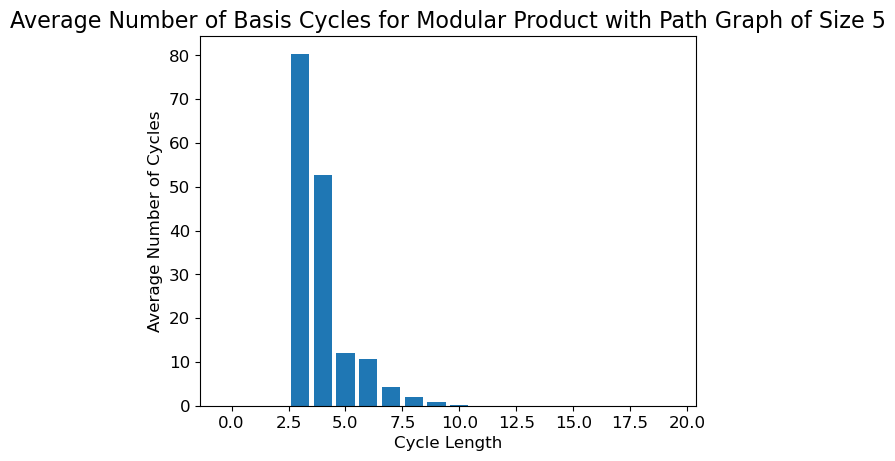

In [13]:
modular_path_5 = cycle_embedded_products.loc['P5', 'Modular']

avg_cycles_per_length = modular_path_5.mean(axis=0)

plt.bar(range(0, 20), avg_cycles_per_length[:20])
plt.xlabel("Cycle Length", fontsize=12)
plt.ylabel("Average Number of Cycles", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Average Number of Basis Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
plt.show()

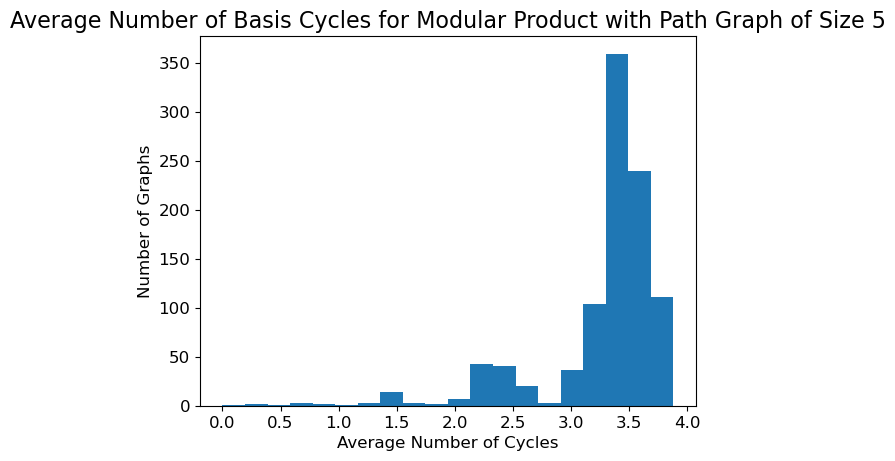

In [14]:
avg_cycles_per_graph = modular_path_5.mean(axis=1)

plt.hist(avg_cycles_per_graph, bins=20)
plt.xlabel("Average Number of Cycles", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Average Number of Basis Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
plt.show()

We also want to find the average density of the graphs that are part of a collision.

In [15]:
collisions = cycle_product_results.map(lambda x: x[1])
collision_participants = collisions.map(lambda cs: {G for collision in cs for G in collision})
collision_density = collision_participants.map(lambda cp: [Gs[G].number_of_edges() / (Gs[G].number_of_nodes() * (Gs[G].number_of_nodes() - 1) / 2) for G in cp])
avg_collision_density = collision_density.map(np.mean)
avg_collision_density

Graph Product,Cartesian,Direct,Strong,Modular
Factor Graph,,,,
K3,0.498676,0.528672,0.539256,0.529420
K5,0.433231,0.548208,0.533863,0.551486
K7,0.430841,0.553788,0.533863,0.551486
P3,0.526499,0.534002,0.536775,0.628571
P5,0.528187,0.509200,0.565760,0.498089
P7,0.528187,0.514286,0.560584,0.514460
S3,0.555609,0.534786,0.532466,0.581032
S5,0.568515,0.533807,0.532893,0.594673
S7,0.568515,0.533807,0.524292,0.594673


### Visualization
Seeing the effectiveness of the graph products, we will further investigate the embeddings of them by visualizing them. We will use the following visualization methods:
* Examples of graphs with the same embedding (before and after graph products)
* Examples of graphs with the same embedding (only after graph products)
* Examples of graphs with different embeddings (only after graph products)
* Examples of graphs with same embeddings after various graph products
* t-SNE

In [16]:
original_idx = cycle_results[1]
comparative_idx = cycle_product_results.loc['P3', 'Modular'][1]

def sort_by_simiplicity(idx_pairs):
    """
    Sorts the index pairs by the combined number of nodes of both graphs.
    If the number of nodes is equal, the number of edges is used.
    This helps to find graphs, that are understandable by humans.
    """
    return sorted(idx_pairs, key=lambda x: (num_nodes[x[0]] + num_nodes[x[1]], num_edges[x[0]] + num_edges[x[1]]))

def plot_dual_examples(set_idx_pairs, num_examples=3, sort=True, fix_positions=False, contains_cycle=False):
    if sort:
        idx_pairs = sort_by_simiplicity(set_idx_pairs)
    else:
        idx_pairs = list(set_idx_pairs)
    
    if contains_cycle:
        for pair in idx_pairs:
            try:
                nx.find_cycle(Gs[pair[0]])
                nx.find_cycle(Gs[pair[1]])
            except nx.exception.NetworkXNoCycle:
                idx_pairs.remove(pair)


    for i in range(num_examples):
        if i >= len(idx_pairs):
            print("Warning: Not enough examples to plot")
            break

        graph_pair = [Gs[idx_pairs[i][0]], Gs[idx_pairs[i][1]]]
        
        pos = nx.spring_layout(graph_pair[0]) if fix_positions else None
        plot(graph_pair, titles=['Graph 1', 'Graph 2'], figsize=(10, 5), pos=pos)


#### Examples of graphs with the same embedding (before and after graph products)

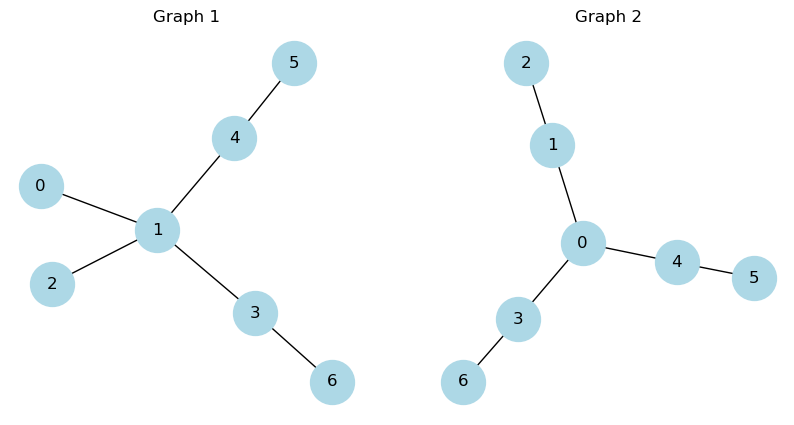

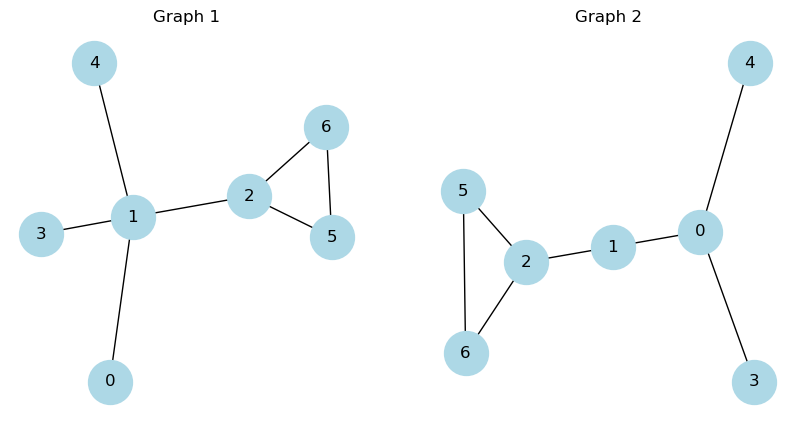

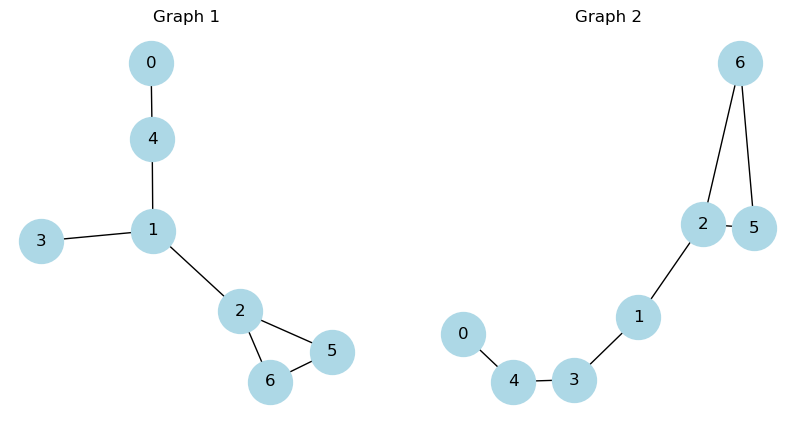

In [17]:
common_idx = original_idx.intersection(comparative_idx)

plot_dual_examples(common_idx)

#### Examples of graphs with the same embedding (only after graph products)

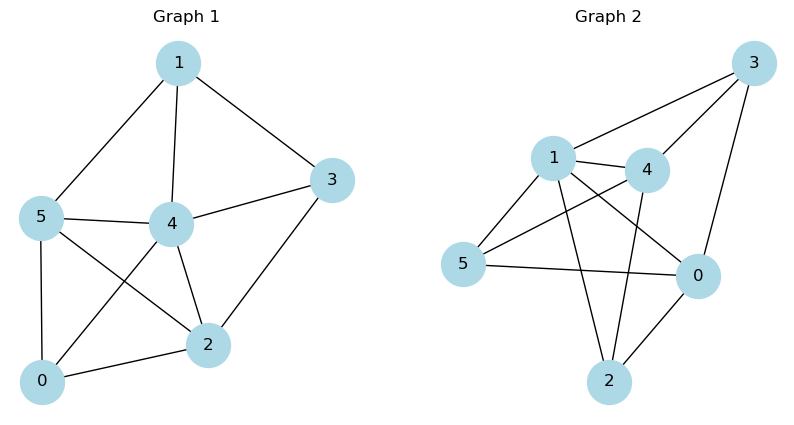

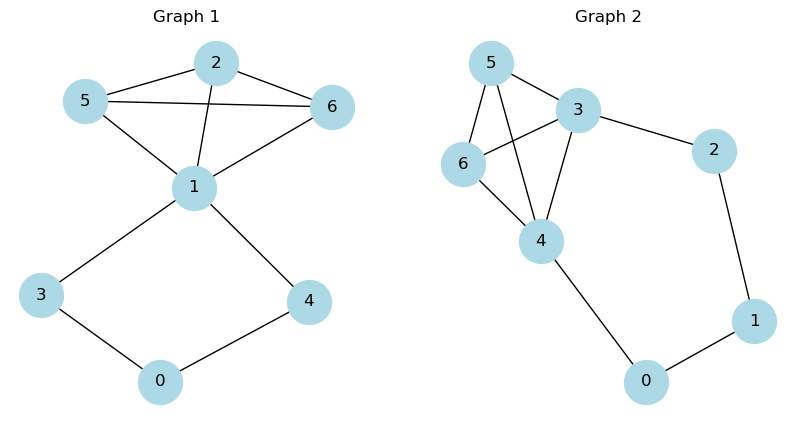

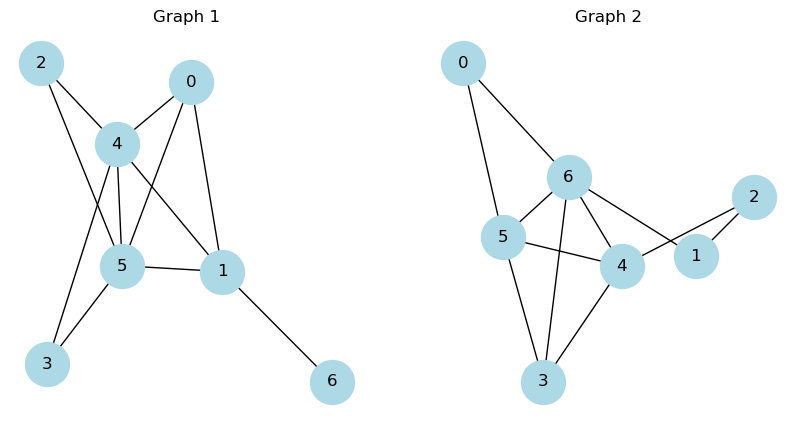

In [18]:
same_only_after_idx = comparative_idx - original_idx

plot_dual_examples(same_only_after_idx)

#### Examples of graphs with different embeddings (only after graph products)

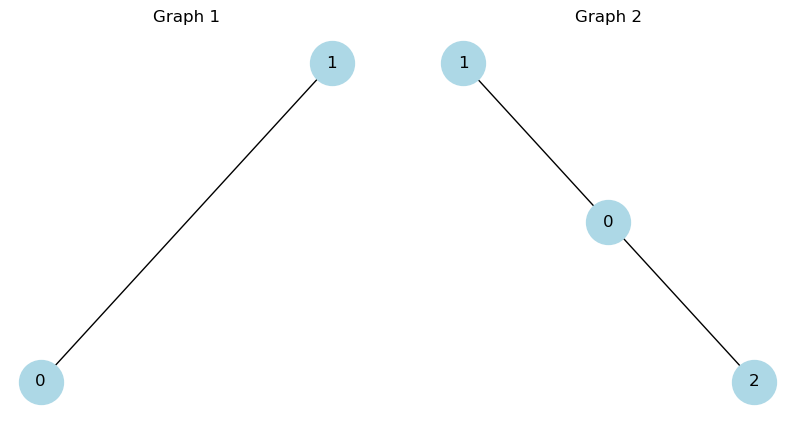

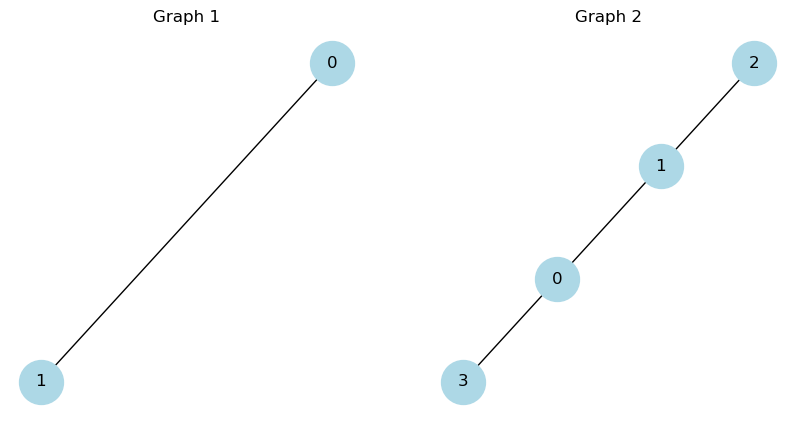

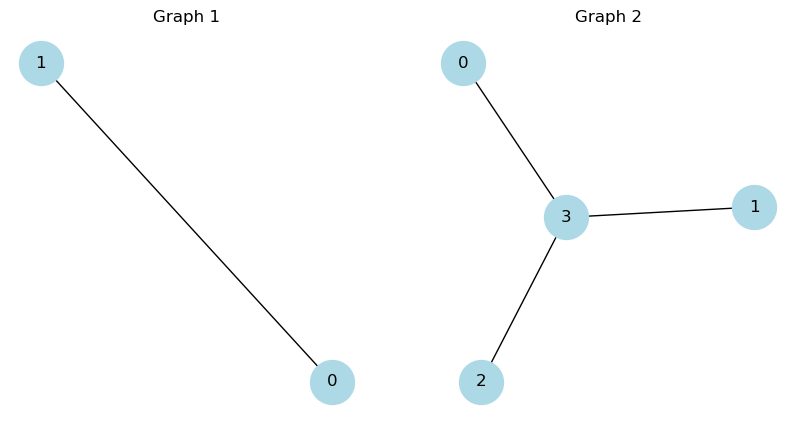

In [19]:
different_only_after_idx = original_idx - comparative_idx

plot_dual_examples(different_only_after_idx)

#### Examples of graphs with same embeddings after various graph products

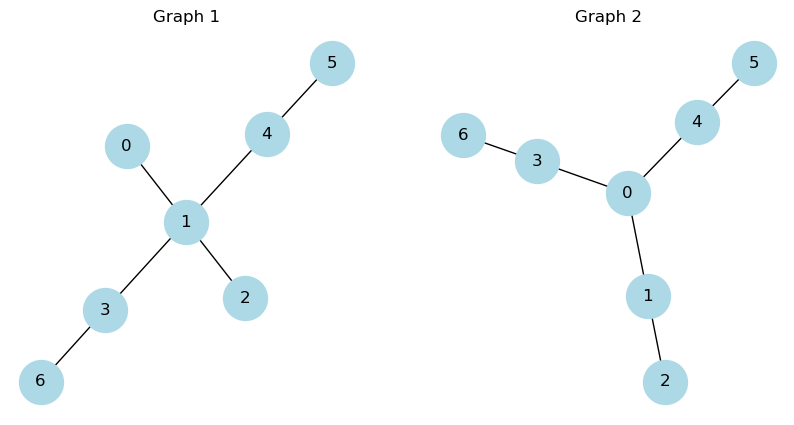

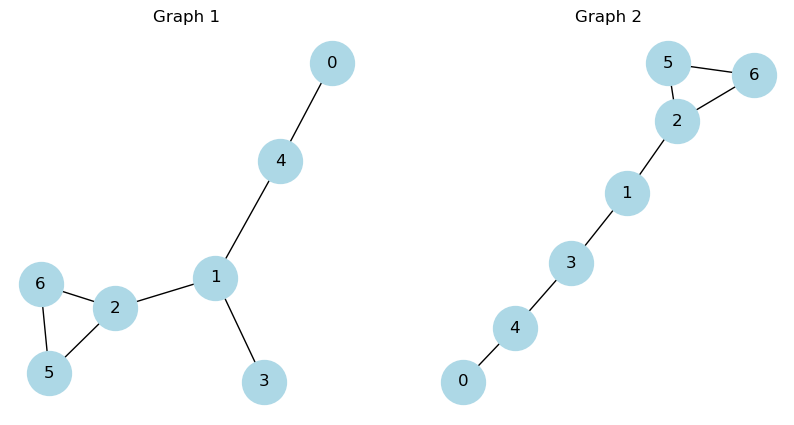

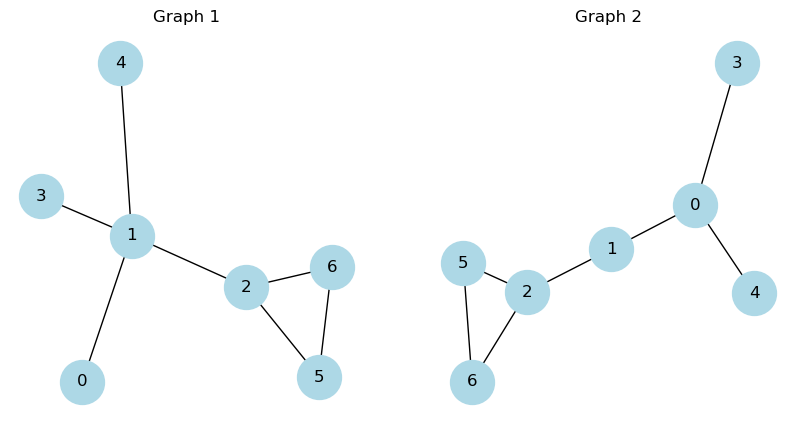

In [20]:
# Change the factor graphs to compare and the graph products to compare
factor_graphs_to_compare = ['P3', 'P5']
graph_products_to_compare = ['Modular', 'Modular']

similar_for_all_idx = original_idx.intersection(*cycle_product_results.loc[factor_graphs_to_compare, graph_products_to_compare].map(lambda x: x[1]).values.flatten())

plot_dual_examples(similar_for_all_idx)

#### t-SNE
The **T-distibuted Stochastic Neighbor Embedding** (t-SNE) is a dimensionality reduction technique, that is often used for visualizing high-dimensional data. It is a non-linear technique, that is particularly well suited for embedding data into a space of two or three dimensions, which can then be visualized in a scatter plot. Specifically, it models each high-dimensional object in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

We will use t-SNE to visualize the embeddings of the graphs. We employ different color schemes to represent categorical attributes of the graphs, such as the number of nodes, the number of edges, and the highest degree.

In [21]:
# Choose one of the options to be the color mapping for the t-SNE plots
cmap_num_nodes = ("Number of Nodes", num_nodes)
cmap_num_edges = ("Number of Edges", num_edges)
cmap_highest_degree = ("Highest Degree", highest_degree)
cmap_node_normalized_highest_degree = ("Node Normalized Highest Degree", node_normalized_highest_degree)
cmap_edge_normalized_highest_degree = ("Edge Normalized Highest Degree", edge_normalized_highest_degree) 

# Change this variable to change the color mapping
color_mapping = cmap_num_edges

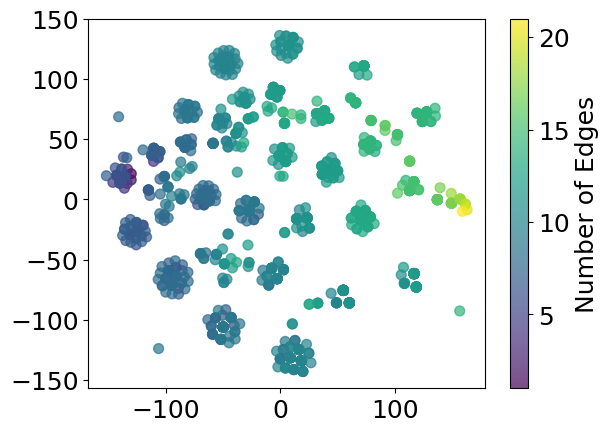

In [22]:
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, random_state=42)
tsne_graphs = tsne.fit_transform(cycle_embedded_graphs)

sc = plt.scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
plt.tick_params(axis='both', which='major', labelsize=18)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(color_mapping[0], fontsize=18)
save_pdf(plt, 'tsne_original_basis')
plt.show()

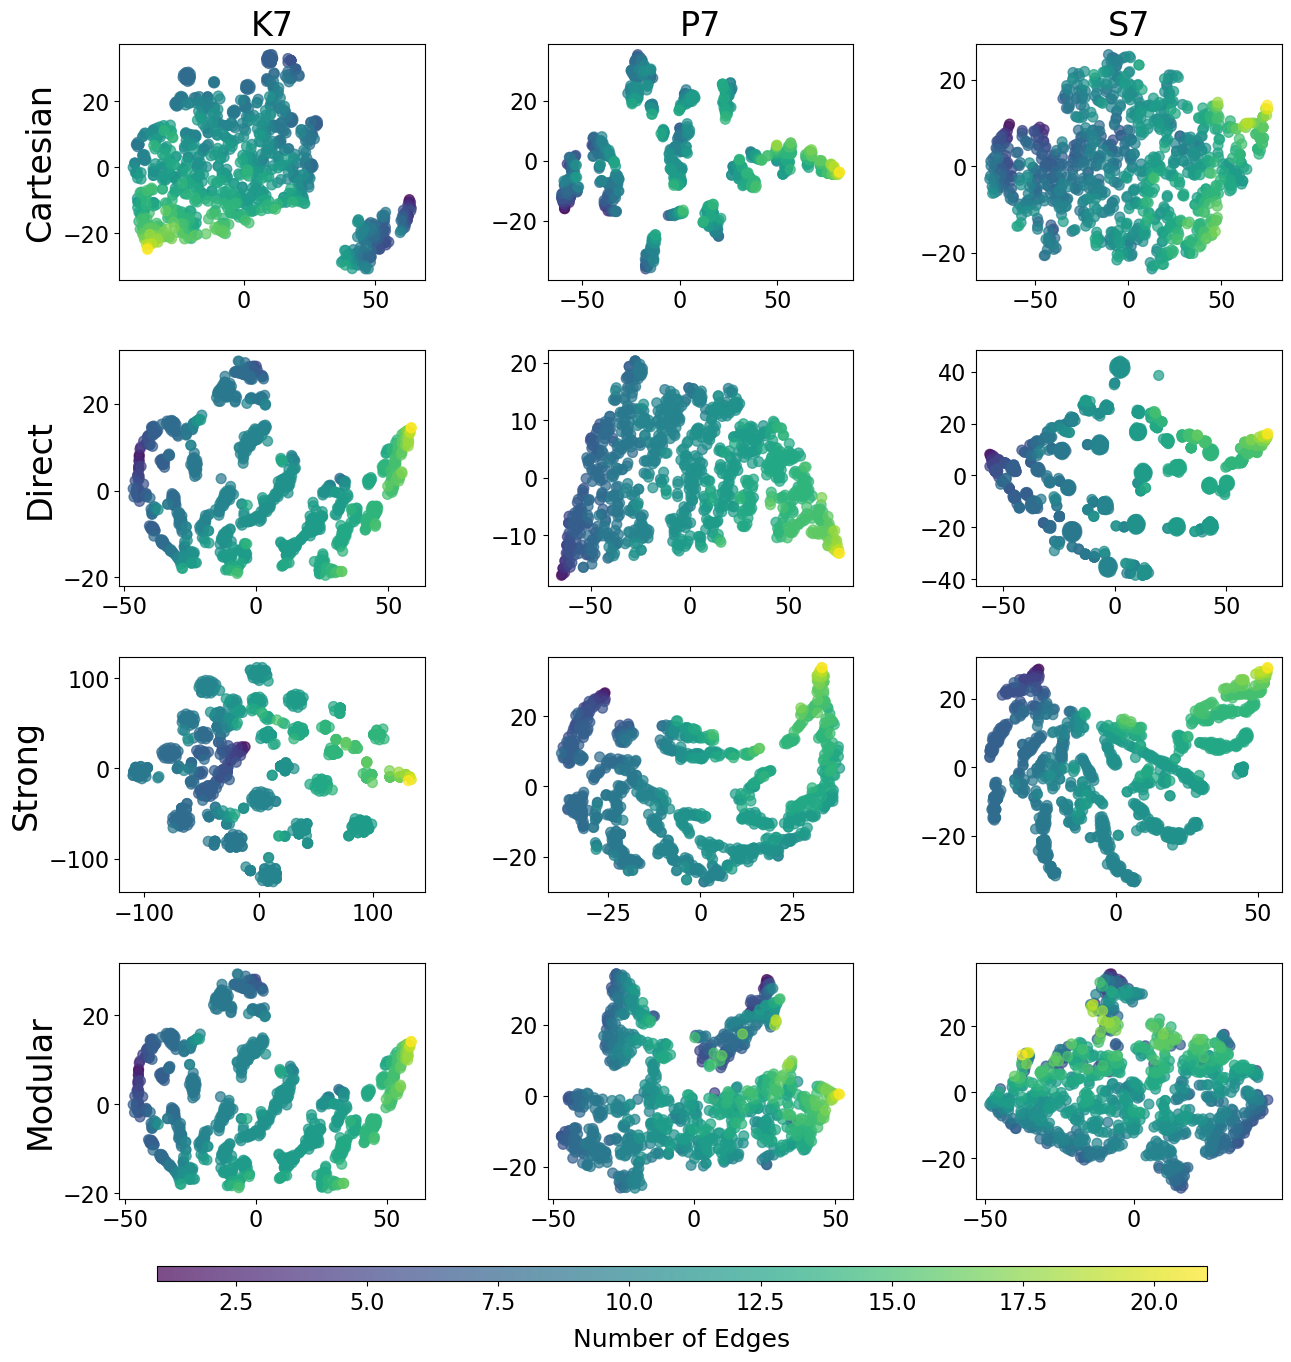

In [50]:
chosen_factor_graphs = ['K7', 'P7', 'S7']

fig, axes = plt.subplots(len(cycle_embedded_products.columns),
                         len(chosen_factor_graphs), 
                         figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for j, factor_graph in enumerate(chosen_factor_graphs):
    comparative_cycle_embedded_graphs = cycle_embedded_products.loc[factor_graph]
    for i, (product_name, embeddings) in enumerate(comparative_cycle_embedded_graphs.items()):
        tsne = TSNE(n_components=2, random_state=42)
        tsne_graphs = tsne.fit_transform(embeddings)
        sc = axes[i, j].scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
        axes[i, j].tick_params(axis='both', which='major', labelsize=16)

    axes[0, j].set_title(factor_graph, fontsize=24)

for i, product_name in enumerate(cycle_embedded_products.columns):
    axes[i, 0].set_ylabel(product_name, fontsize=24)

cbar_ax = fig.add_axes([0.15, 0.055, 0.7, 0.01])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(color_mapping[0], fontsize=18, labelpad=10)

save_pdf(plt, 'tsne_product_basis')
plt.show()

## Union Embeddings
This section will explore the effect of combining embeddings from different product-factor combinations, and how this affects the ability to distinguish between graphs. For this we will simply concatenate the embeddings of the different product-factor combinations.

In [24]:
used_products = graph_products.columns
union_products = [(x, y) for x in used_products for y in used_products if x != y]

cycle_embedded_union = pd.DataFrame(index=factor_graphs.keys(), columns=union_products)
cycle_embedded_union.index.name = 'Factor Graph'
cycle_embedded_union.columns = pd.MultiIndex.from_tuples(cycle_embedded_union.columns, names=['Product 1', 'Product 2'])

for factor_name in factor_graphs:
    for product1, product2 in union_products:
        cycle_embedded_union.loc[factor_name, (product1, product2)] = np.concatenate([cycle_embedded_products.loc[factor_name, product1], cycle_embedded_products.loc[factor_name, product2]], axis=1)


cycle_union_results = cycle_embedded_union.map(lambda x: compare(x, index=True))

cycle_union_results.map(lambda x: x[0])

Product 1    Cartesian                   Direct                   Strong  \
Product 2       Direct Strong Modular Cartesian Strong Modular Cartesian   
Factor Graph                                                               
K3                 146    865     143       146    565     542       865   
K5                  32    748      29        32    261     257       748   
K7                  29    748      28        29    254     257       748   
P3                 402    186      20       402    395      29       186   
P5                  48     58      28        48     39      26        58   
P7                  24     54      19        24     19      22        54   
S3                 105     45      14       105    417      30        45   
S5                  86     41      14        86    470      27        41   
S7                  86     38      14        86    334      27        38   

Product 1                     Modular                
Product 2    Direct Modular Cartesian Direct Strong  
Factor Graph                                         
K3              565     542       143    542    542  
K5              261     251        29    257    251  
K7              254     251        28    257    251  
P3              395      19        20     29     19  
P5               39      31        28     26     31  
P7               19      26        19     22     26  
S3              417      15        14     30     15  
S5              470      16        14     27     16  
S7              334      15        14     27     15

### Results and Discussion
We will discuss the results of the previous sections and draw conclusions.

Applying the graph products to graphs before embedding them using a cycle counting approach has show to be effective. The number of graphs that are mapped to the same embedding is reduced drastically. Interestingly, we can note the effectiveness of different graph products with specific factor graphs. For example, the direct product with a complete graph or a path grap as a factor graph is very effective, while the direct product with a star graph as a factor graph is not very effective. Conversely, the Cartesian product with a star graph as a factor graph is very effective, while the Cartesian product with a complete graph or a path graph as a factor graph is not very effective. The strong product is especially effective with the path graph. 

The combination of the modular- and strong graph products with the path graph as a factor graph are the most effective combinations. They are able to map all but 5 graph pairs to different embeddings. This is a very good result, even improving upon the results of the Weisfeiler-Lehman algorithm, which has a total of 20 graph pairs that are mapped to the same embedding.

The t-SNE visualization corroborates the results, as described above. We can see that for certain combinations of graph products and factor graphs, the embedding space is evenly separated, whereas for other combinations, there are narrow clusters of embeddings, which indicates that many graphs are mapped to the same embedding.

## Chordless Cycle counting
Now we will count chordless cycles of different lengths. We will then use different graph products and observe, how the cycle counts change. The process is similar to the basys cycle counting method, but we will use a reduced set of graph products and factor graphs, as the computational complexity of counting chordless cycles is higher than counting basis cycles.

In [25]:
red_factor_graphs = get_factor_dict([3, 5, 7], sep_self_loop_node=False)
red_graph_products = generate_graph_product_table(Gs, products=["Cartesian", "Direct", "Strong", "Modular"], factors=red_factor_graphs)

### Embeddings
For all these graph products, as well as the initial graphs, we will create embeddings by counting cycles of different lengths. We will use an embedding size of 7*7=49, which is the maximum length of cycles in a graph product of two graphs with each 7 nodes.

In [26]:
chordless_cycle_embedder = ChordlessCycleEmbedding(size=49)
chord_cycle_embedded_graphs = chordless_cycle_embedder(Gs)
chord_cycle_embedded_products = red_graph_products.map(lambda x: chordless_cycle_embedder(x, True))

100%|██████████| 995/995 [17:10<00:00,  1.04s/it]


### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [27]:
chord_cycle_results = compare(chord_cycle_embedded_graphs, index=True)
chord_cycle_product_results = chord_cycle_embedded_products.map(lambda x: compare(x, index=True))

In [28]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(chord_cycle_results[0]))

Number of non-isomorphic graphs with the same embedding: 6989


In [51]:
chord_cycle_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Direct,Strong,Modular
Factor Graph,,,,
K3,1245,0,3952,0
K5,1244,0,3952,0
K7,1244,0,3952,0
P3,1,332,11,0
P5,0,12,0,0
P7,0,5,0,0
S3,0,350,5,0
S5,0,362,5,0
S7,0,327,5,0


To further analyze the workings of chordless cycle, we will look at the average number of chordless cycles for the modular product with a path graph of size 5.

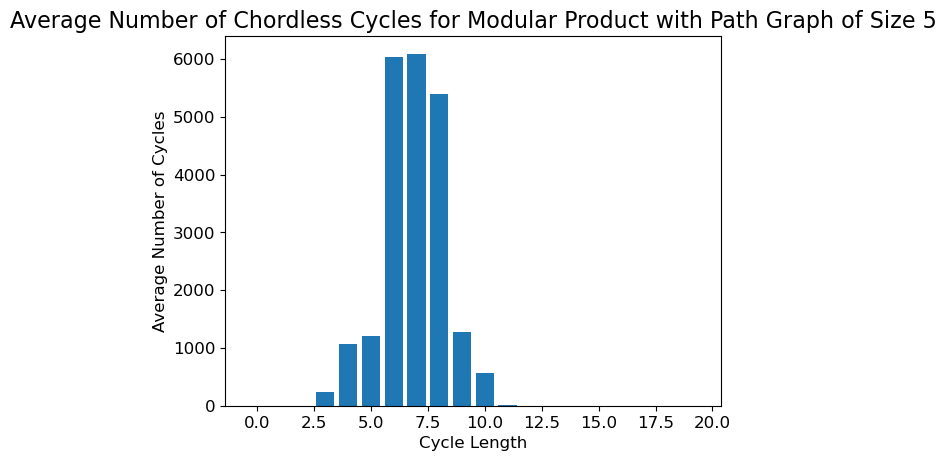

In [30]:
chord_modular_path_5 = chord_cycle_embedded_products.loc['P5', 'Modular']

chord_avg_cycles_per_length = chord_modular_path_5.mean(axis=0)

plt.bar(range(0, 20), chord_avg_cycles_per_length[:20])
plt.xlabel("Cycle Length", fontsize=12)
plt.ylabel("Average Number of Cycles", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Average Number of Chordless Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
save_pdf(plt, 'chordless_cycle_avg')
plt.show()

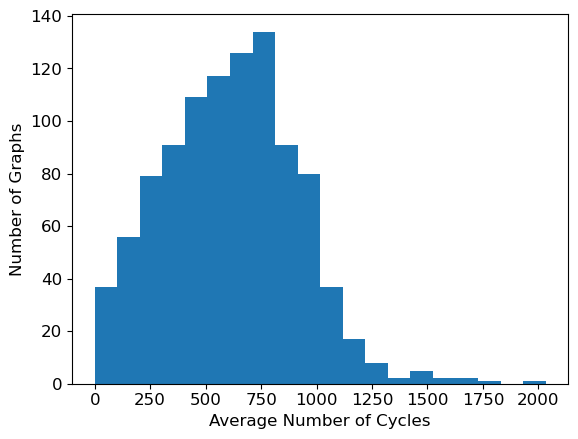

In [71]:
chord_avg_cycles_per_graph = chord_cycle_embedded_products.loc['S5', 'Modular'].mean(axis=1)

plt.hist(chord_avg_cycles_per_graph, bins=20)
plt.xlabel("Average Number of Cycles", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.title("Average Number of Chordless Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
save_pdf(plt, 'chordless_cycle_hist')
plt.show()

Seeing the effectiveness of the graph products, we will further investigate the embeddings of them by visualizing them. We will use the following visualization methods:
* Examples of graphs with the same embedding (before and after graph products)
* Examples of graphs with the same embedding (only after graph products)
* Examples of graphs with different embeddings (only after graph products)
* Examples of graphs with same embeddings after various graph products

In [32]:
chord_original_idx = chord_cycle_results[1]
chord_comparative_idx = chord_cycle_product_results.loc['K7', 'Direct'][1]

#### Examples of graphs with the same embedding (before and after graph products)

In [33]:
chord_common_idx = chord_original_idx.intersection(chord_comparative_idx)

plot_dual_examples(chord_common_idx)

#### Examples of graphs with the same embedding (only after graph products)

In [34]:
chord_same_only_after_idx = chord_comparative_idx - chord_original_idx

plot_dual_examples(chord_same_only_after_idx)

#### Examples of graphs with different embeddings (only after graph products)

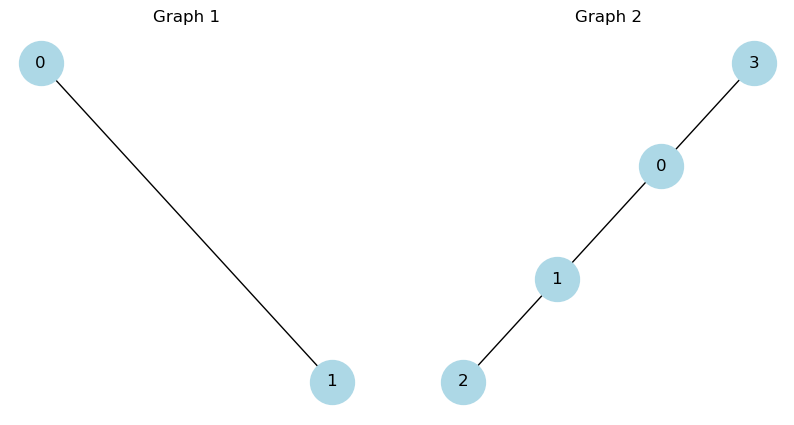

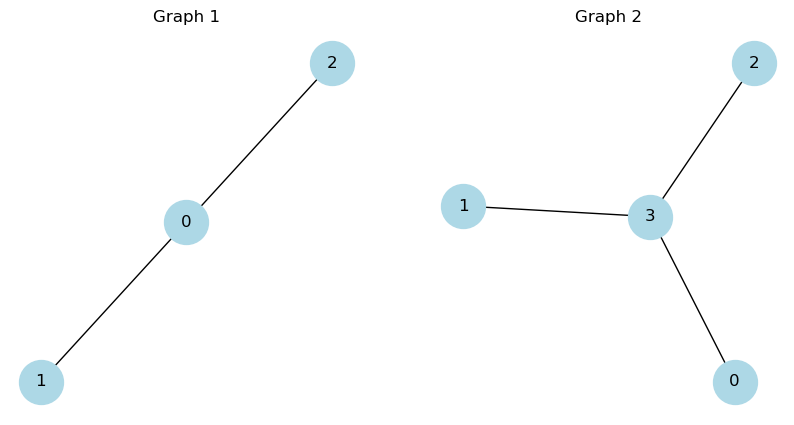

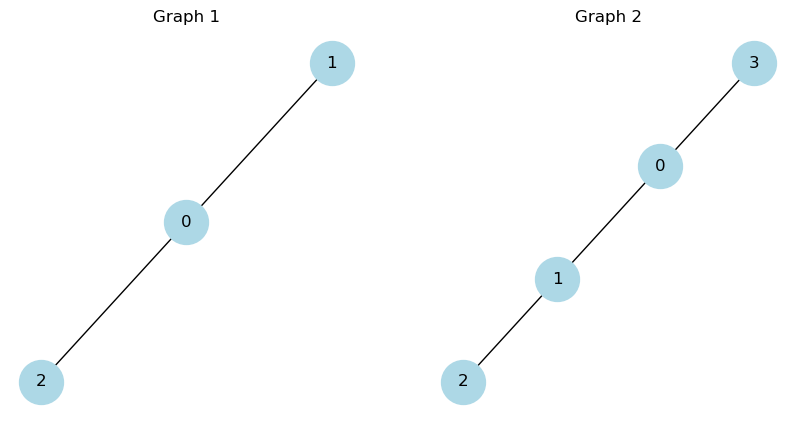

In [35]:
chord_different_only_after_idx = chord_original_idx - chord_comparative_idx

plot_dual_examples(chord_different_only_after_idx, contains_cycle=True)

#### Examples of graphs with same embeddings after various graph products

In [36]:
# Change the factor graphs to compare and the graph products to compare
chord_factor_graphs_to_compare = ['K7', 'P7']
chord_graph_products_to_compare = ['Modular', 'Direct']

chord_similar_for_all_idx = chord_original_idx.intersection(*chord_cycle_product_results.loc[chord_factor_graphs_to_compare, chord_graph_products_to_compare].map(lambda x: x[1]).values.flatten())

plot_dual_examples(chord_similar_for_all_idx)

### t-SNE
We will again observe the t-SNE visualization of the embeddings.

In [37]:
# Choose one of the options to be the color mapping for the t-SNE plots
cmap_num_nodes = ("Number of Nodes", num_nodes)
cmap_num_edges = ("Number of Edges", num_edges)
cmap_highest_degree = ("Highest Degree", highest_degree)
cmap_node_normalized_highest_degree = ("Node Normalized Highest Degree", node_normalized_highest_degree)
cmap_edge_normalized_highest_degree = ("Edge Normalized Highest Degree", edge_normalized_highest_degree) 

# Change this variable to change the color mapping
color_mapping = cmap_num_edges

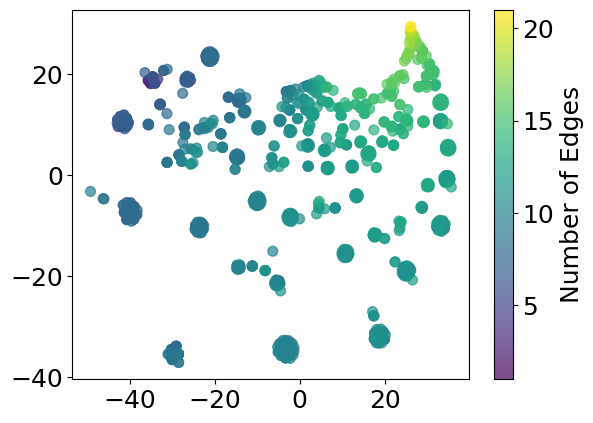

In [38]:
tsne = TSNE(n_components=2, random_state=42)
tsne_graphs = tsne.fit_transform(chord_cycle_embedded_graphs)

sc = plt.scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
plt.tick_params(axis='both', which='major', labelsize=18)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(color_mapping[0], fontsize=18)
save_pdf(plt, 'tsne_original_chordless')
plt.show()

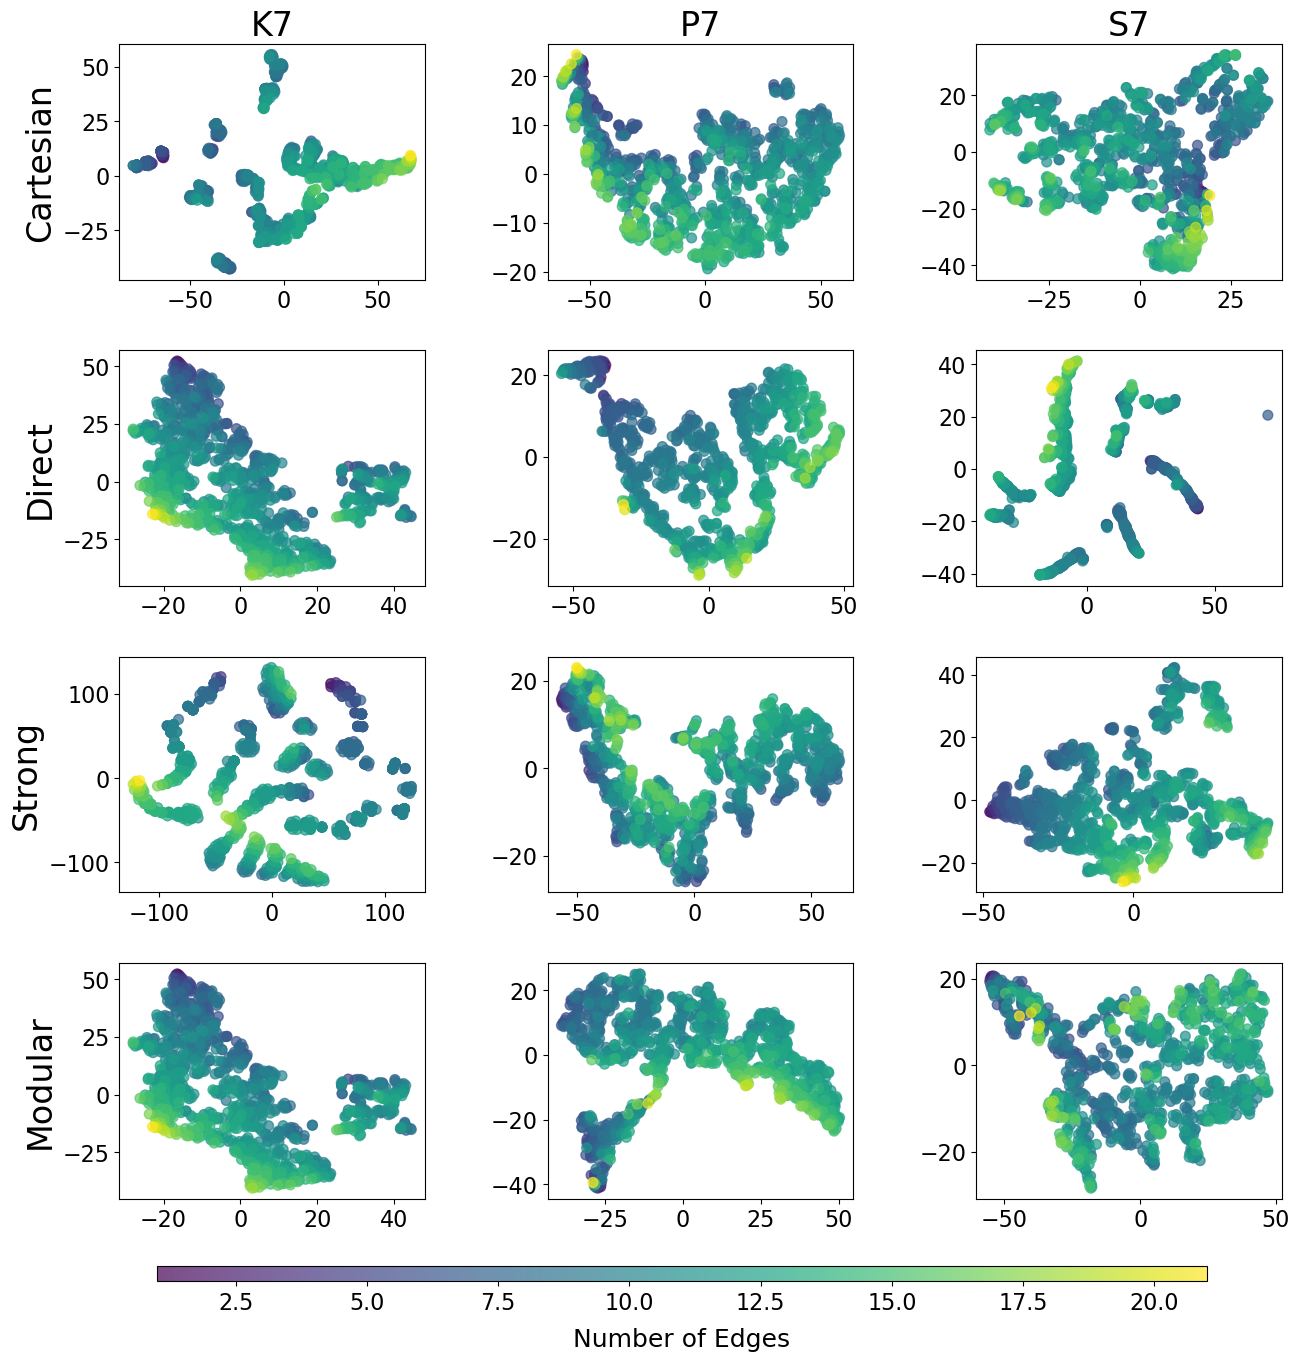

In [49]:
chosen_factor_graphs = ['K7', 'P7', 'S7']

fig, axes = plt.subplots(len(chord_cycle_embedded_products.columns),
                         len(chosen_factor_graphs), 
                         figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for j, factor_graph in enumerate(chosen_factor_graphs):
    comparative_cycle_embedded_graphs = chord_cycle_embedded_products.loc[factor_graph]
    for i, (product_name, embeddings) in enumerate(comparative_cycle_embedded_graphs.items()):
        tsne = TSNE(n_components=2, random_state=42)
        tsne_graphs = tsne.fit_transform(embeddings)
        sc = axes[i, j].scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
        axes[i, j].tick_params(axis='both', which='major', labelsize=16)

    axes[0, j].set_title(factor_graph, fontsize=24)

for i, product_name in enumerate(chord_cycle_embedded_products.columns):
    axes[i, 0].set_ylabel(product_name, fontsize=24)

cbar_ax = fig.add_axes([0.15, 0.055, 0.7, 0.01])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(color_mapping[0], fontsize=18, labelpad=10)


save_pdf(plt, 'tsne_product_chordless')
plt.show()


### Union Embeddings
Lastly, we will again explore the effect of combining embeddings from different product-factor combinations, and how this affects the ability to distinguish between graphs. For this we will simply concatenate the embeddings of the different product-factor combinations.

In [40]:
union_products = [(x, y) for x in chord_cycle_embedded_products.columns for y in chord_cycle_embedded_products.columns if x != y]

chord_cycle_embedded_union = pd.DataFrame(index=red_factor_graphs.keys(), columns=union_products)
chord_cycle_embedded_union.index.name = 'Factor Graph'
chord_cycle_embedded_union.columns = pd.MultiIndex.from_tuples(chord_cycle_embedded_union.columns, names=['Product 1', 'Product 2'])

for factor_name in red_factor_graphs:
    for product1, product2 in union_products:
        chord_cycle_embedded_union.loc[factor_name, (product1, product2)] = np.concatenate([chord_cycle_embedded_products.loc[factor_name, product1], chord_cycle_embedded_products.loc[factor_name, product2]], axis=1)


chord_cycle_union_results = chord_cycle_embedded_union.map(lambda x: compare(x, index=True))

chord_cycle_union_results.map(lambda x: x[0])

Product 1    Cartesian                   Direct                   Strong  \
Product 2       Direct Strong Modular Cartesian Strong Modular Cartesian   
Factor Graph                                                               
K3                   0   1245       0         0      0       0      1245   
K5                   0   1244       0         0      0       0      1244   
K7                   0   1244       0         0      0       0      1244   
P3                   1      1       0         1      8       0         1   
P5                   0      0       0         0      0       0         0   
P7                   0      0       0         0      0       0         0   
S3                   0      0       0         0      5       0         0   
S5                   0      0       0         0      5       0         0   
S7                   0      0       0         0      5       0         0   

Product 1                     Modular                
Product 2    Direct Modular Cartesian Direct Strong  
Factor Graph                                         
K3                0       0         0      0      0  
K5                0       0         0      0      0  
K7                0       0         0      0      0  
P3                8       0         0      0      0  
P5                0       0         0      0      0  
P7                0       0         0      0      0  
S3                5       0         0      0      0  
S5                5       0         0      0      0  
S7                5       0         0      0      0

## Weisfeiler-Lehman
Next will use the standard one dimensional Weisfeiler-Lehman isomorphism test and perform the same evaluations and comparisons as before.

### Embeddings
We will use 10 iterations of the Weisfeiler-Lehman algorithm to create the embeddings.

In [41]:
wl_embedded_graphs = wl(Gs, 10)
wl_embedded_products = graph_products.map(lambda x: wl(x, 10))

### Evaluation and Comparison
In this section, we will evaluate the effectiveness of graph products ability to enhance the WL isomorphism test. 

In [42]:
wl_results = compare(wl_embedded_graphs)
wl_product_results = wl_embedded_products.map(lambda x: compare(x, index=True))

In [43]:
wl_results

20

In [44]:
wl_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Direct,Strong,Modular
Factor Graph,,,,
K3,20,20,20,20
K5,20,20,20,20
K7,20,20,20,20
P3,20,20,20,20
P5,20,20,20,20
P7,20,20,20,20
S3,20,20,20,20
S5,20,20,20,20
S7,20,20,20,20


As we can see from the table above, the graph products showed no effect on enhancing the WL isomorphism test.

## Cycle counting vs. Weisfeiler-Lehman
In this section we will compare the cycle counting approach with the Weisfeiler-Lehman algorithm. More specifically, we will visualize non-isomorphic graphs that are not correctly identified by the Weisfeiler-Lehman algorithm, but are distinctly embedded by the cycle counting approach.

First, we will analyze how many collisions are present in **both** the embeddings of the Weisfeiler-Lehman algorithm **and** the cycle counting approach

In [45]:
collision_intersections = pd.DataFrame(index=factor_graphs.keys(), columns=used_products)

for factor_graph in factor_graphs:
    for product_name in used_products:
        collision_intersections.loc[factor_graph, product_name] = len(wl_product_results.loc[factor_graph, product_name][1].intersection(cycle_product_results.loc[factor_graph, product_name][1]))

collision_intersections

Graph Product,Cartesian,Direct,Strong,Modular
K3,0,0,2,0
K5,0,0,2,0
K7,0,0,2,0
P3,1,3,0,0
P5,1,1,0,0
P7,1,0,0,0
S3,1,4,0,0
S5,1,4,0,0
S7,1,4,0,0


As the set difference of the two sets of collisions shows, Nearly all collisions of the Weisfeiler-Lehman algorithm distinct from the collisions of the cycle counting approach. We will now visualize collisions of the Weisfeiler-Lehman algorithm and subsequently collisions of the cycle counting approach.

In [46]:
collision_wl_idx = wl_product_results.loc['P3', 'Modular'][1]
collision_cycle_idx = cycle_product_results.loc['P3', 'Modular'][1]

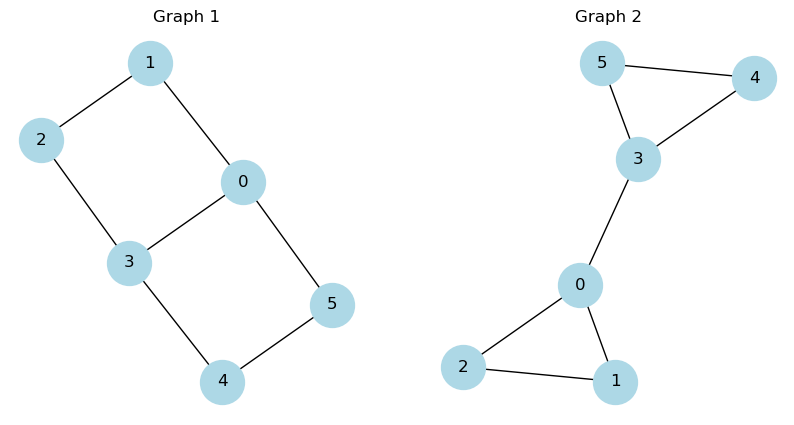

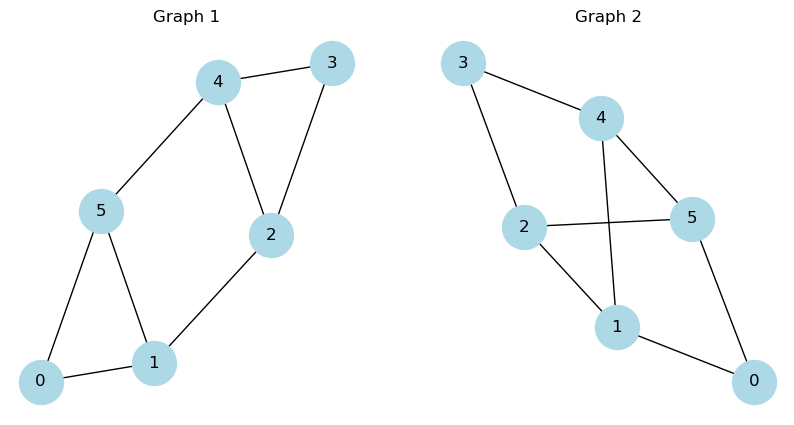

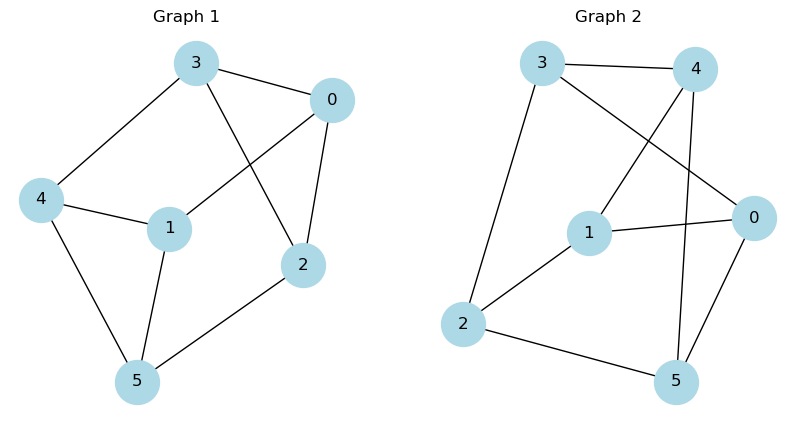

In [47]:
plot_dual_examples(collision_wl_idx, num_examples=3)

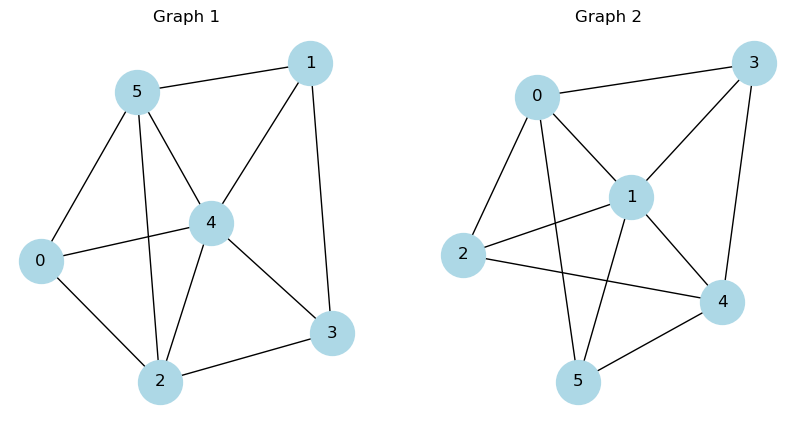

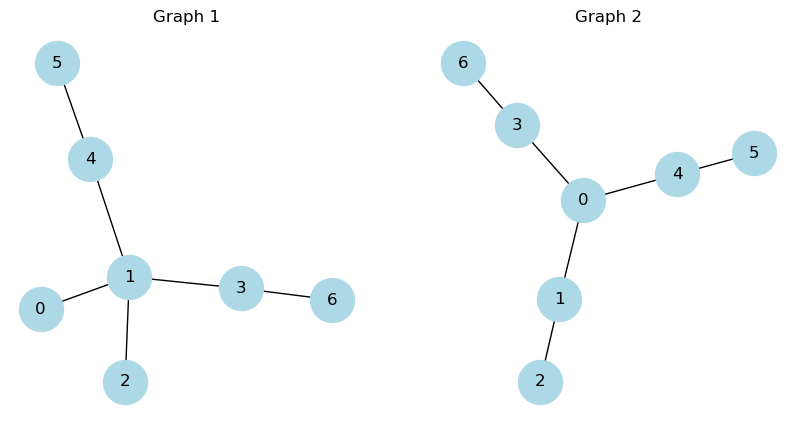

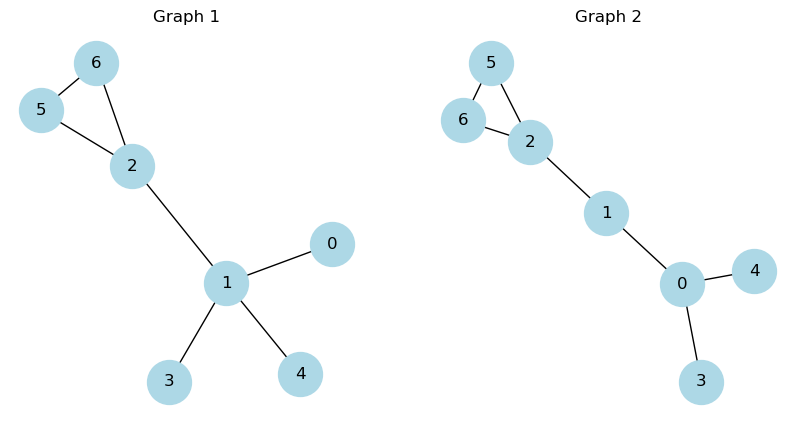

In [48]:
plot_dual_examples(collision_cycle_idx, num_examples=3)